In [5]:
import pandas as pd

sales_doc = "../doccuments/sales_and_eodStocks.xlsx"
transactions_doc = "../doccuments/transactions.xlsx"

sales_df = pd.read_excel(sales_doc)
transactions_df = pd.read_excel(transactions_doc)

In [6]:
print(sales_df.head())

  Product_ID       Date  Sales  Revenue  EndOfDayStock
0      10002 2009-12-01     12    10.20          48692
1      10002 2009-12-03      7     5.95          48685
2      10002 2009-12-04     73    62.05          48612
3      10002 2009-12-06     49    41.65          48563
4      10002 2009-12-07      2     1.70          48561


In [7]:
print(transactions_df.head())

   Invoice Product_ID                          Description  Quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

                 Date  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom  


In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_data(df, columns, method='standardization'):
    """
    Scale the specified columns of the dataframe using the chosen method.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    columns (list): List of column names to be scaled.
    method (str): The scaling method - 'standardization' or 'normalization'.

    Returns:
    pandas.DataFrame: The dataframe with the specified columns scaled.
    """
    scaler = StandardScaler() if method == 'standardization' else MinMaxScaler()

    # Scale only the specified columns
    df_scaled = df.copy()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])

    return df_scaled

# Example usage
# Assuming df is your DataFrame and you want to scale 'Sales' and 'Revenue'
scaled_df = scale_data(sales_df, ['Sales', 'Revenue'], method='minmax')
print(scaled_df[scaled_df['Revenue'] == scaled_df['Revenue'].max()])


       Product_ID       Date  Sales  Revenue  EndOfDayStock
334816      23843 2011-12-09    1.0      1.0              0


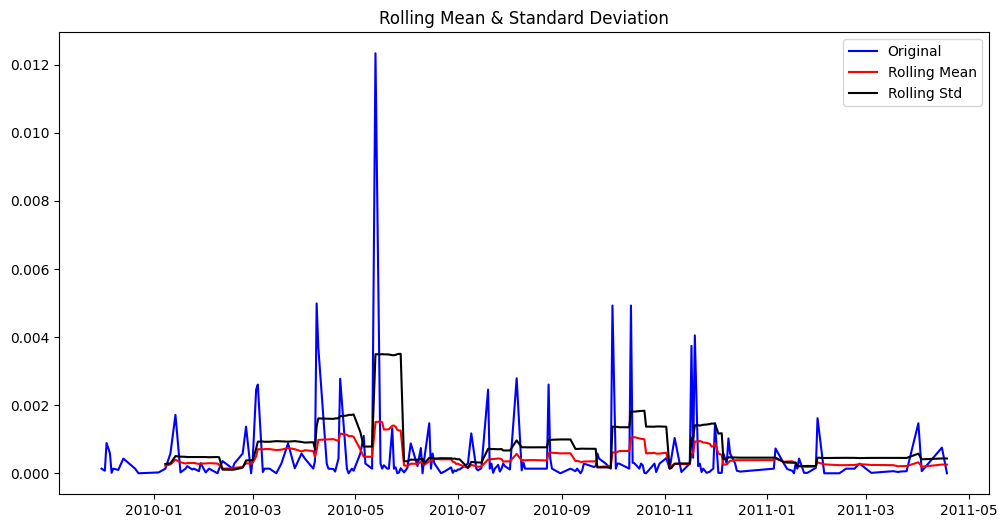

Results of Dickey-Fuller Test:


Test Statistic                -1.379254e+01
p-value                        8.871168e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

In [22]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Filter the data for one specific product
product_data = scaled_df[scaled_df['Product_ID'] == scaled_df['Product_ID'].unique()[0]].copy()

# Set the Date as the index
product_data.set_index('Date', inplace=True)

# Focus on the Sales column for ARIMA
sales_data = product_data['Sales']

# Check for stationarity
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Testing stationarity
test_stationarity(sales_data)


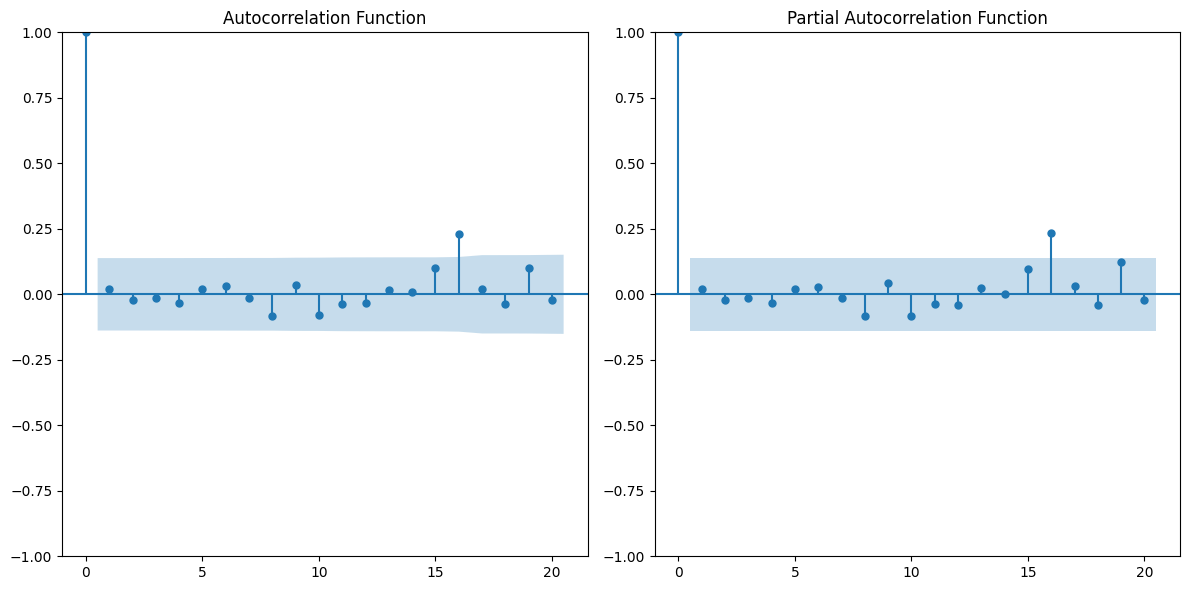

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(sales_data, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(sales_data, ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


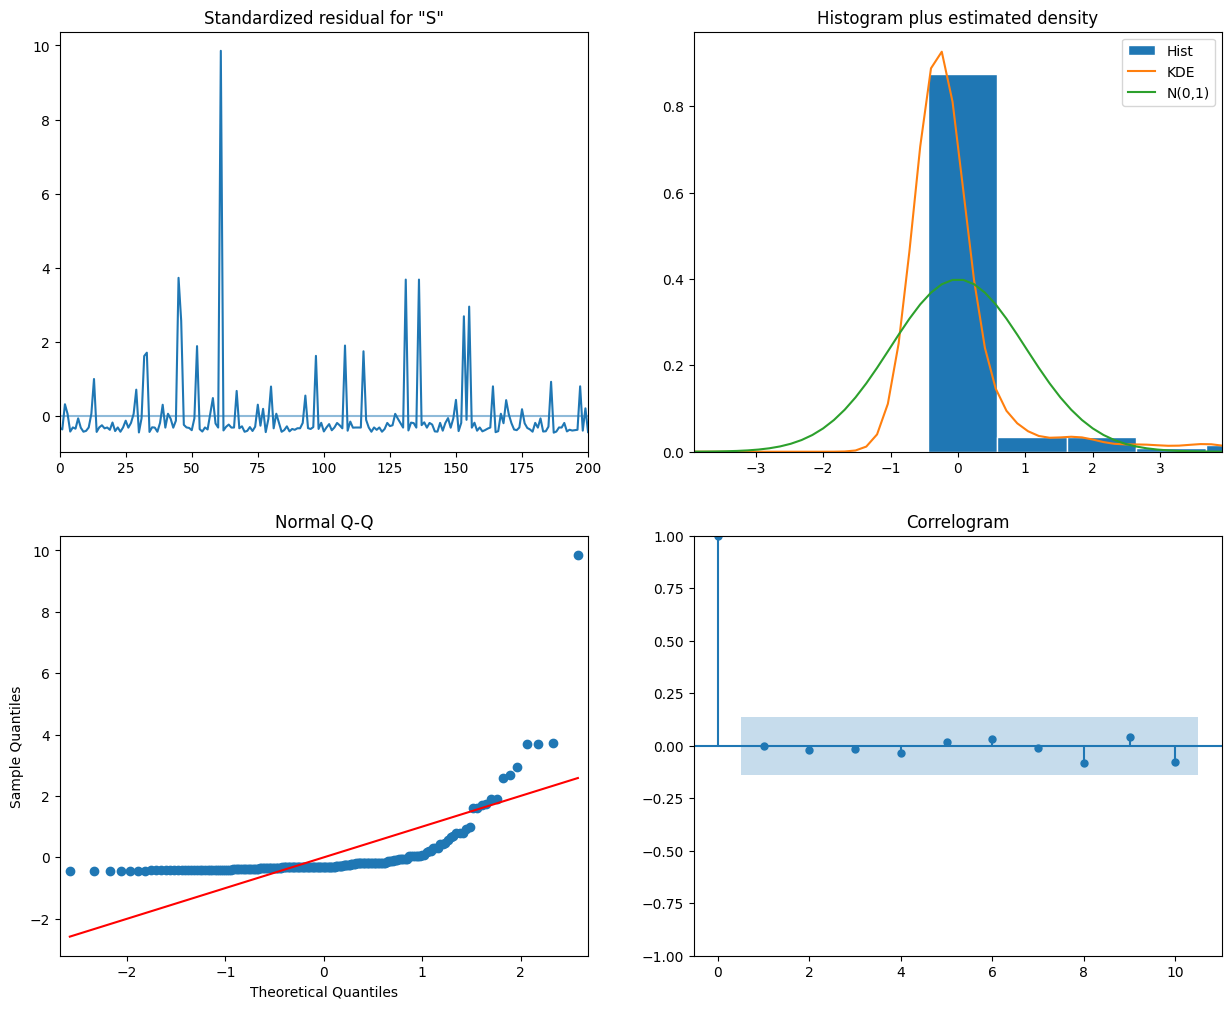

/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(sales_data, order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
model_summary = model_fit.summary()
# Model Diagnostics
model_diagnostics = model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting with the model
# For demonstration, let's forecast the next 10 periods
forecast = model_fit.get_forecast(steps=10)
forecast_index = pd.date_range(start=sales_data.index[-1], periods=11, closed='right')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting the forecast
plt.figure(figsize=(12,6))
plt.plot(sales_data, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Sales Forecast')
plt.legend()
plt.show()

